# Exercise 3

In [31]:
library(lubridate)
library(Hmisc)
library(readxl) # read and modify excel files
library(matrixStats) # used to get the standard deviation by rows
library(pracma) #for meshgrid

#Fancy tables 
library(formattable)

In [2]:
#Reading xls file
data <- read_excel("Statistics_DataExercise3.xls" , na="ND",range = cell_cols(1:13))[1:22,]
colnames(data)[colnames(data)=="...1"] <- "Years"         # Renaming column 1 to Years
N <- rowSums(!is.na(data[2:13])) #Number of months

New names:
* `` -> ...1


In [3]:
data.matrix <- matrix(days_in_month(seq(from=as.Date("1984-1-1"), to=as.Date("2005-12-1"), by="month")), 
                      ncol=12, byrow=TRUE)

# <p style="color:red">Part 1</p>
##  Fraction Lost vs Years

a) Convert nights to fraction of nights for each month 

In [4]:
fraction.nights <- data[2:13] / data.matrix

b) Mean fraction + error **in the mean**

In [5]:
fraction.mean <- rowMeans(fraction.nights, na.rm=TRUE)
fraction.sd <- rowSds(as.matrix(fraction.nights), na.rm=TRUE)
error.mean <-  fraction.sd / sqrt(N) 

c)Final table: YEAR FRACLOST ERROR

In [6]:
#Creating a data frame with Year-FracLost-Error
customRed = "e3866f"
data.df<- data.frame("Year" = as.numeric(data$Years), "FracLost" = fraction.mean, "Error" = error.mean)

In [7]:
#Creating a fancy table
as.htmlwidget(formattable(data.df, align=c("l", "c", "c"),
                          list(`Year` = formatter("span", style = ~ style(color = "grey",font.weight = "bold")), 
                               `FracLost`= color_bar(customRed), 
                               `Error`=formatter("span", style=~style(color=customRed)))))

HTML widgets cannot be represented in plain text (need html)

> `formatter` creates a fancy table from a data.frame. The command `align`is used to locate the elements of each column: "l" for left and "c" for center. The list created is used to format the color, font style and other things (if desire) of the table. Also, this was made following the example from [r-blogger](https://www.r-bloggers.com/make-beautiful-tables-with-the-formattable-package/)

<div class="alert alert-block alert-warning">
`as.htmlwidget` is necessary here since in Jupyter-lab (for some reason) the `formatter` doesn't seem to return anything different for the `data.frame`created
<\div>

d) Plot FRACLOST vs YEAR (`errbar`)

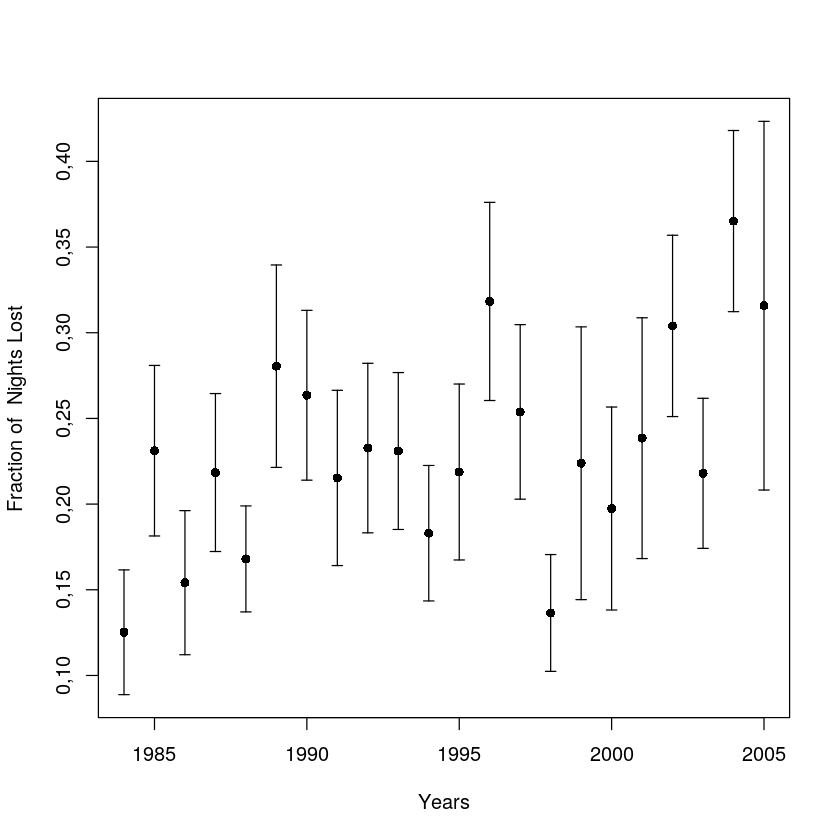

In [8]:
error.plus <- fraction.mean + error.mean
error.minus <- fraction.mean - error.mean

errbar(as.numeric(data$Years), fraction.mean, error.plus, error.minus, xlab="Years", 
       ylab="Fraction of  Nights Lost")

## Fit to a constant

a) Use `lm` and `analytical expression` to fit a constant

In [9]:
# Fitting with lm
weight <- 1 / (data.df$Error^2)
y <- data.df$FracLost

fit_lm <- lm(y ~ 1, weights=weight)
coef(fit_lm)

(Intercept) 
  0,2115525

**Analytical expression** 
$$ a_0 = \frac{\sum_{i=1}^{N} y_i /\sigma_i^2}{\sum_{i=1}^{N} 1 / \sigma_i^2} $$

In [10]:
# Fitting with analytical expression
acte <- function(y, error){
    #' Returns fit to a constant
    num <- sum(y / error^2, na.rm=TRUE)
    den <- sum(1 / error^2, na.rm=TRUE)
    return(num / den)
}

rbind("Fit Constant: "= acte(data.df$FracLost, data.df$Error))

Fit Constant:,"0,2115525"


b) Calculate 𝜒2 (define a function for 𝜒2 where the model is a line)

In [11]:
# Chi square
Chisq <- function(params, x, y, error){
    #' Computes Chi square for linear model
    a <- params[1]
    b <- params[2]
    num <- y - a - (b * x)
    den <- error
    frac <- (num / den)^2
    output <- sum(frac)
    return(output)
}

# Parameters for this model
a <- coef(fit_lm)
b <- 0
x <- 0
y <- data.df$FracLost
error <- data.df$Error

#Chisq
Chisq(c(a,b), x, y, error)

[1] 34,65221

c) Calculate 90% confidence interval (analytical)

From [Practical Statistics for Astronomers](https://ned.ipac.caltech.edu/level5/Wall2/Wal3_4.html),the way to calculate the 90% confidence interval is (for n = 1 DoF),

$$\Delta \chi ^2 = 2.71 \\
\chi_{0.90}^2 = \chi_{min}^2 + 2.71 \\
\chi_{0.90}^2 = 0.016 \\
a_{0.90} =  a_0 \pm \sqrt{\frac{2.71}{\sum (1/\sigma_i^2)}}$$

In [12]:
conf.a <- function(error, a0){
    #' Returns the 90% confidence interval for chi square (1 DoF)
    E <- sum(1 / error^2)
    x <- sqrt(2.71 / E)
    a.right <- a0 + x
    a.left <- a0 - x
    return(rbind("left" = a.left, "right" = a.right))
}

#params
err <- data.df$Error
a0 <- coef(fit_lm)

conf.a(err, a0)

,(Intercept)
left,"0,1948689"
right,"0,2282361"


## Fitting Quality

a) `P(chi2,nu)` = Probability that `chi2 < chi2min` if the model is correct

In [13]:
chi <- Chisq(c(a, b), x, y, error)
df <- length(data.df$Year) - 1
Q <- pchisq(chi, df=df, lower.tail=FALSE)

rbind("P"=1-Q, "Chi square" = chi, "Q"=Q)

P,"0,96918284"
Chi square,"34,65221055"
Q,"0,03081716"


b) Q (goodness of fit) = Probability that `chi2 > chi2min` if the model is correct
```R
p(H0)= Q = pchisq(...,lower.tail=FALSE)
```
Good fit: `P` small & `Q=1-P` large

If `Q=1-P < 0.01%`: model is not consistent with the data

In [14]:
Q

[1] 0,03081716

## Fit to a straight line
```R
fraction.mean = a + b * data$Years
```
a) Best fit (by `lm`) and plot

In [15]:
weight <- 1 / (data.df$Error^2)
y <- data.df$FracLost
x <- data.df$Year

linear.fit <- lm(y~x, weights = weight)
coef(linear.fit)

(Intercept)            x 
-8,946365394  0,004594915

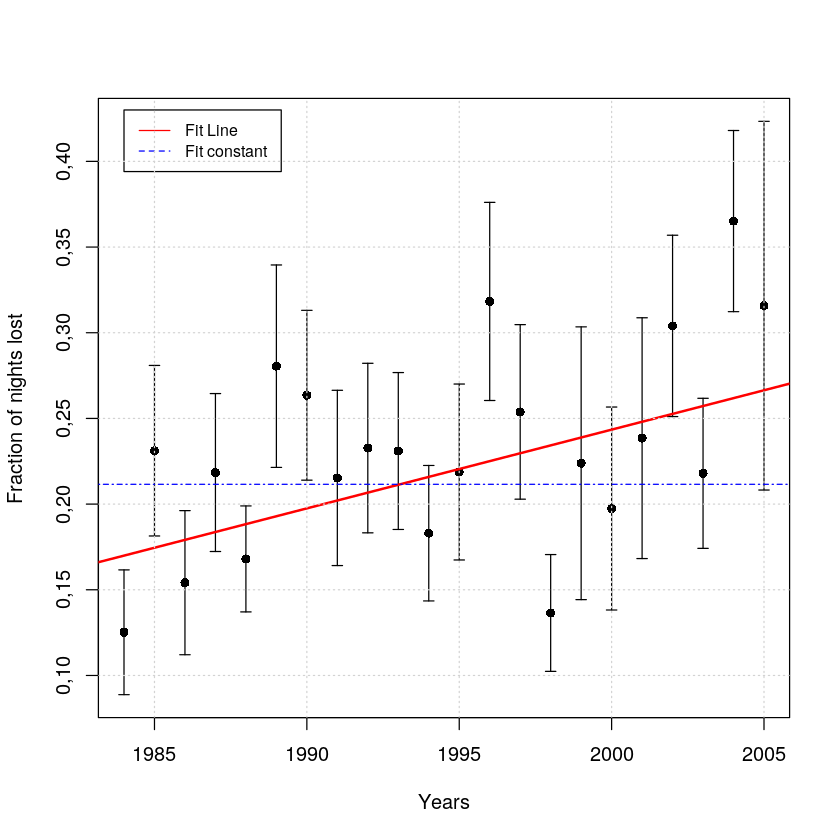

In [16]:
err <- data.df$Error

#png("plot1.png", width=800, height=800)
errbar(x, y, yplus = y + err, yminus = y - err, xlab="Years", ylab="Fraction of nights lost")
abline(linear.fit, col="red", lw=2)
abline(fit_lm, col="blue", lw=1, lty=16)
legend(1984, 0.43, legend=c("Fit Line", "Fit constant"),
       col=c("red", "blue"), lty=1:2, cex=0.8)
grid()
#dev.off()

b)Best fit con `optim` (`fun.to.minimize = chi2`, for a line, 2 params)  

In [17]:
optim.fit <- optim(c(a,b), Chisq, x=x, y=y, error=err)
a0 <- optim.fit$par[1]
b0 <- optim.fit$par[2]
chi2.min <- Chisq(c(a0,b0), x=x, y=y, error=err)

rbind("a0 "=a0, "b0" =b0, "Chi2 min"=chi2.min )

,(Intercept)
a0,"-8,945323646"
b0,"0,004594392"
Chi2 min,"26,842521277"


c) Confidence intervals 90% and 99% (analytical) 

If only the slope is interesting (1 parameter) ...

$$ 99\% \rightarrow \Delta \chi^{2} = 6.63 \\
90\% \rightarrow \Delta \chi^{2} = 2.71 \\
b_{\delta} = b_0 \pm \sigma_0 \sqrt{\Delta \chi^2} \\
\frac{1}{\sigma_0^2} = S_{xx} - \frac{S_x^2}{S}$$

In [18]:
sigma0 <- function(error, x, y){
    S <- sum(1 / error^2)
    Sxx <- sum(x^2 / error^2)
    Sx2 <- sum(x  / error^2)^2
    output <- sqrt(1 / (Sxx - (Sx2/S)))
    return(output)
}
conf.b <- function(b0, s0, delta){
    #' Returns the confidence interval of b for a linear model chisquare
    b.left <- b0 - (s0 * sqrt(delta))
    b.right <- b0 + (s0 *  sqrt(delta))
    return(rbind("left:"=b.left, "right:"=b.right))
}

#params for conf.b
s0 <- sigma0(error=err, x = data.df$Year, y = data.df$FracLost)
d1 <- 2.71
d2 <- 6.63
# 90%
cbind("90%"=conf.b(b0, s0, delta= d1), "99%"= conf.b(b0, s0, delta= d2))

,,
left:,"0,001887660","0,0003607188"
right:,"0,007301124","0,0088280654"


d)`Ftest: F, pF, improve=1-pF` (grande para que el modelo mejore) (se pueden usar los resultados del fit)

In [19]:
F <- function(chi, v){
    #' Returns the F value for models with chi square
    # Chi is a list with chi square of model 1 and model 2
    # v is a list with parameters v of model 1 and model 2
    X1 <- chi[1]
    X2 <- chi[2]
    v1 <- v[1]
    v2 <- v[2]
    num <- (X1 - X2) / (v1 - v2) 
    den <- X2 / v2
    return(num / den)
}

n <- length(N)
v <- c(n -1, n - 2)
chi.list <- c(chi, chi2.min)
PF <- pf(F(chi.list, v), df1= v[1], df2 = v[2])
F1 <- F(chi.list, v)

rbind("F"=F1, "pf" = PF, "Improve" = 1 -PF)

F,"5,8188939783"
pf,"0,9998905915"
Improve,"0,0001094085"


In [20]:
pchisq(chi2.min, df=v[2], lower.tail=FALSE)


[1] 0,139753

# <p style="color:red"> Part 2</p>

## Fraction Lost vs Month

a) Fit to a constant and give $\chi^2$

In [21]:
N.col <- colSums(!is.na(data[2:13])) 
month.mean <- colMeans(fraction.nights, na.rm=TRUE)
month.sd <- colSds(as.matrix(fraction.nights), na.rm=TRUE)
month.error <- month.sd / sqrt(N.col)

#Fit
weight <- 1 / (month.error^2)
y <- month.mean

fit.month <- lm(y ~ 1, weights=weight)

# Chi square
a <- coef(fit.month)
b <- 0
x <- 0
y <- month.mean
err <- month.error

month.chi <- Chisq(c(a, b), x, y, err)


#Q <- pchisq(month.chi, df=1, lower.tail=FALSE)
rbind("Fit a0"=a, "Chi square"= month.chi)


,(Intercept)
Fit a0,"0,1007219"
Chi square,"331,1723526"


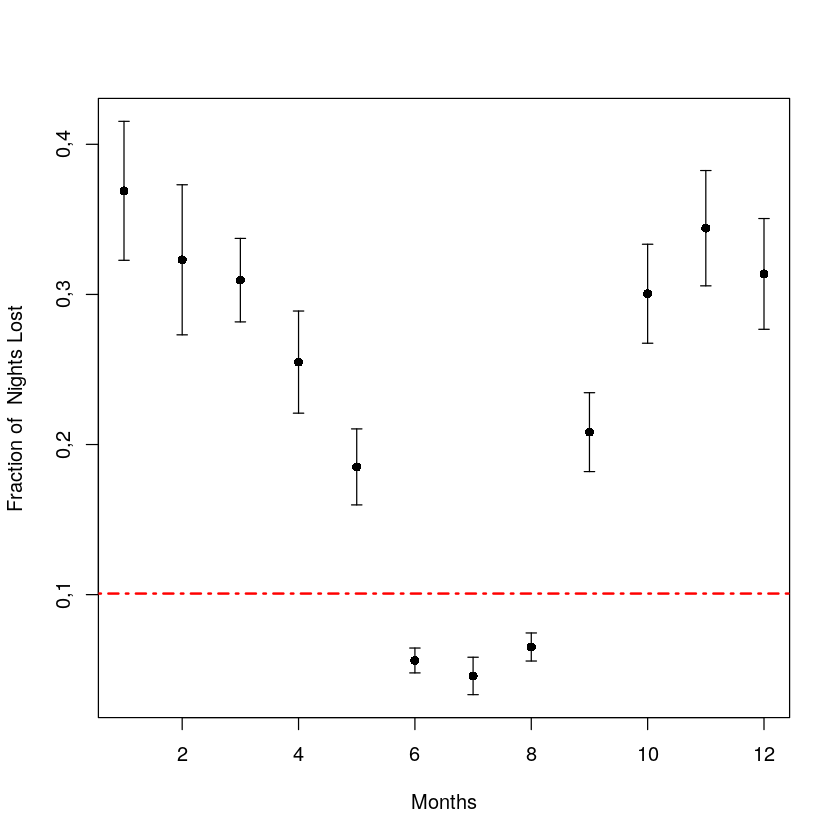

In [22]:
error.plus <- month.mean + month.error
error.minus <- month.mean - month.error

errbar(seq(1,12,1), month.mean, error.plus, error.minus, xlab="Months", 
       ylab="Fraction of  Nights Lost")
abline(fit.month, col="red", lw=2, lty=16)

b) Fit to a function `𝑓𝑙𝑜𝑠𝑡=𝑓𝑐+𝑓𝑒×sin(2𝜋(𝑡−𝑡0)/12)` (3)

In [23]:
chisq.sin <- function(params, x ,y, error){
    #' returns the chi square for the sinusoidal model
    fc <- params[1]
    fe <- params[2]
    t0 <- params[3]
    flost <-  fc + (fe * sin(2 * pi * (x - t0)/ 12))
    num <- (y - flost)^2
    den <- error ^2
    return(sum(num / den))
}
# values
x <- seq(1, 12, 1)
y <- month.mean
err <- month.error
#Initial guess
params <- c(0.4,0,0)

chisin.optim <- optim(params, chisq.sin, x=x , y=y , error=err, hessian=TRUE)

fc <- chisin.optim$par[1]
fe <- chisin.optim$par[2]
t0 <- chisin.optim$par[3]
x1 <- chisq.sin(c(fc,fe,t0), x=x, y=month.mean, error=err)
rbind("Fc:"= fc, "Fe:"=fe, "t0:"=t0, "Chi square"=x1)

Fc:,"0,2260765"
Fe:,"0,1820834"
t0:,"-2,1276618"
Chi square,"24,3691799"


In [24]:
flost <- function(params, x){
    fc <- params[1]
    fe <- params[2]
    t0 <- params[3]
    return(fc + fe * sin(2 * pi * (x - t0)/12))
}

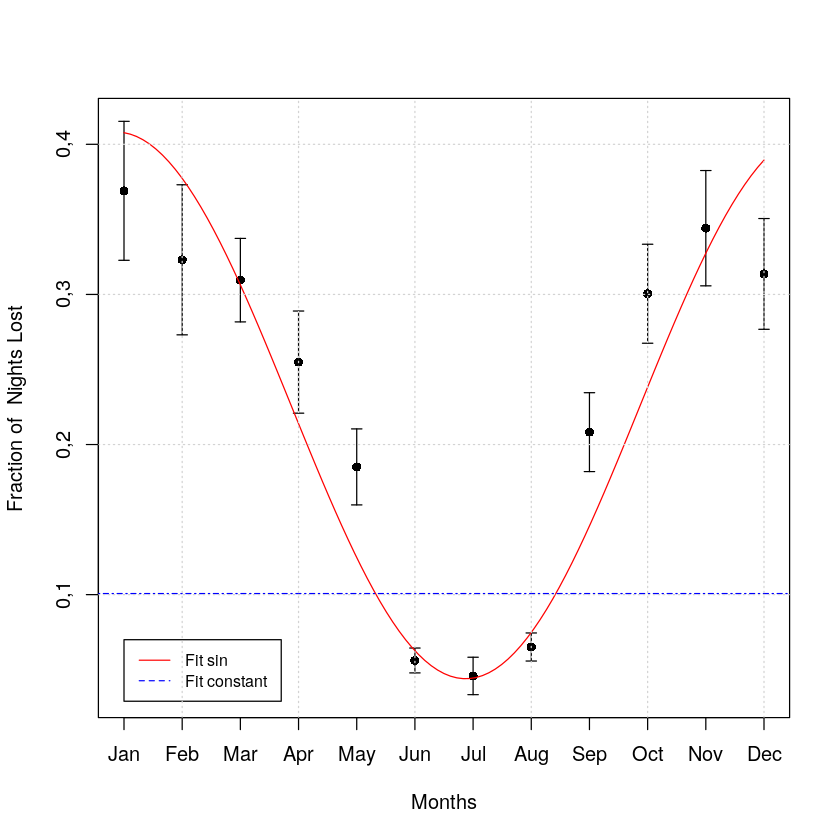

In [25]:
#png("plot2.png", width=800, height=800)
errbar(seq(1,12,1), month.mean, error.plus, error.minus, xlab="Months", 
       ylab="Fraction of  Nights Lost", xaxt = "n")
curve(flost(c(fc, fe, t0), x), col="red", add=T)
abline(fit.month, col="blue", lw=1, lty=16)
legend(1, 0.07, legend=c("Fit sin", "Fit constant"),
       col=c("red", "blue"), lty=1:2, cex=0.8)
axis(1, at = 1:12, labels = c("Jan","Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov","Dec"))
grid()
#dev.off()

c) Confidence interval: Hessian matrices 

In [26]:
err_90 <- sqrt(diag(solve(chisin.optim$hessian/2)))*1.64
f1 <- c(fc - err_90[1], fc+err_90[1]) 
f2 <- c(fe - err_90[2], fe+err_90[2]) 
f3 <- c(t0 - err_90[3], t0+err_90[3]) 
interval <-  data.frame("Interval.left" = c(f1[1], f2[1], f3[1]),"Value"=c("Fc"=fc, "Fe"=fe, "t0"=t0),
                        "Interval.right"=c(f1[2],f2[2],f3[2]))

customBlue = "19876c"
as.htmlwidget(formattable(interval, align=c("l", "c", "c"),
                          list(`Interval.left` = formatter("span", style = ~ style(color = customBlue,font.weight = "bold")), 
                               `Value`= color_bar("3cb899"), 
                               `Interval.right`=formatter("span", style=~style(color=customBlue, font.weight = "bold")))))

HTML widgets cannot be represented in plain text (need html)

### **Optional** Contours (optimize + contour) 

In [27]:
#Function to minimize t0
t0.min <- function(params,fc, fe, x, y, error ){
    t0 <- params[1]
    flost <-  fc + (fe * sin(2 * pi * (x - t0)/ 12))
    num <- (y - flost)^2
    den <- error ^2
    return(sum(num / den)) 
}

# Defining parameters I'm going to use here
x <- seq(1, 12, 1)
y <- month.mean
err <- month.error

n <- 100#length(x)
fc <- seq(0.15, 0.27, length.out = n) #0.226
fe <- seq(0.10, 0.25, length.out = n) #0.182

#Grid
my.grid <- meshgrid(fc, fe)



# Finding min t0 with optimize
t0 <- c()
contour.chi <- c()
for (i in fc){
    for (j in fe){
        t0.vector <- optimize(t0.min, lower=-10 ,upper=10,fc=i, fe=j, x=x, y=y, error=err )$minimum
        t0 <- c(t0, t0.vector)
        params <- c(i,j,t0.vector)
        X2 <- chisq.sin(params, x=x, y=y, error=err)
        contour.chi <- c(contour.chi, X2)
    }
}

In [28]:
CHI2<- matrix(contour.chi, ncol=length(fe), nrow=length(fc),byrow=TRUE)

In [29]:
l1 <- x1 + 4.61 #(90%) 
l2 <- x1 + 6.17 #(95.4%)
l3 <- x1 + 9.21 # 99%
l4 <- x1 + 11.8 #99.73%

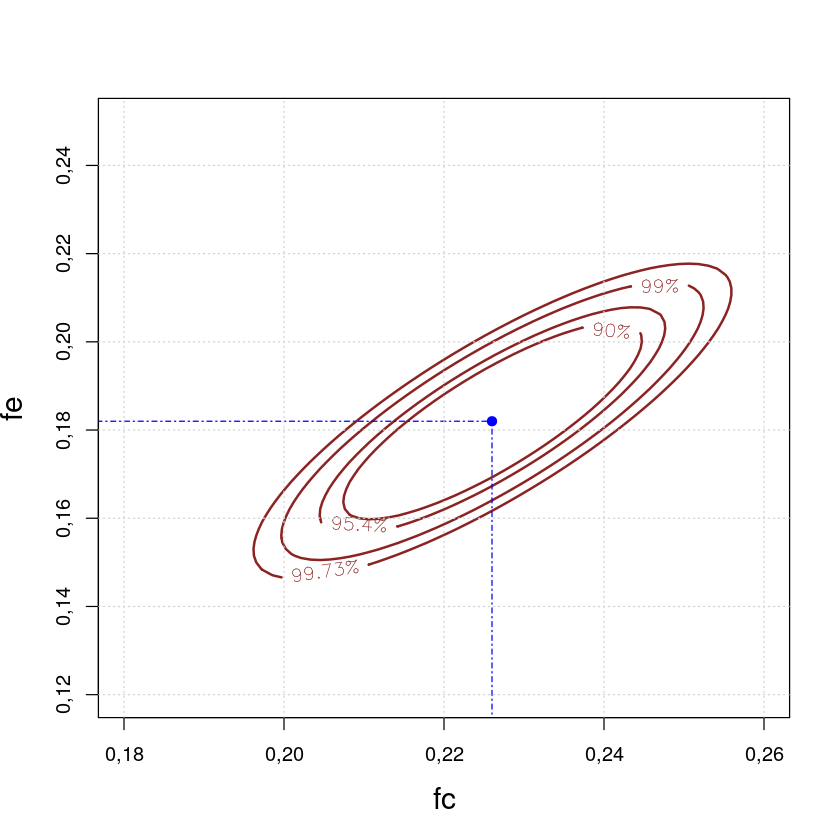

In [32]:
#png("plot3.png", width=800, height=800)
contour(x=fc, y=fe, CHI2, levels=c(l1, l2, l3, l4),
       xlim=(c(0.18, 0.26)), ylim=(c(0.12, 0.25)), col = "brown4", lw=2,
       labcex = 1,xlab = quote(fc), ylab = quote(fe) , cex.lab=1.5, 
        labels=c("90%", "95.4%", "99%", "99.73%"))
points(x=0.226, y=0.182, pch=19, col="blue")
points(c(0.226, 0.226),c(0.1, 0.182), type='l',  col="blue", lty=16)
points(c(0.226, 0.1),c(0.182, 0.182), type='l',  col="blue", lty=16)
grid()
#dev.off()

In [33]:
#Function to minimize t0
t0.min <- function(params,fc, fe, x, y, error ){
    t0 <- params[1]
    flost <-  fc + (fe * sin(2 * pi * (x - t0)/ 12))
    num <- (y - flost)^2
    den <- error ^2
    return(sum(num / den)) 
}

# Defining parameters I'm going to use here
x <- seq(1, 12, 1)
y <- month.mean
err <- month.error
n <- 100#length(x)
fc <- seq(0.15, 0.27, length.out = n) #0.226
fe <- seq(0.10, 0.25, length.out = n) #0.182

#Grid
my.grid <- expand.grid(fc, fe)



# Finding min t0 with optimize
t0 <- c()
contour.chi <- c()
for (i in fc){
    for (j in fe){
        t0.vector <- optimize(t0.min, lower=-10 ,upper=10,fc=i, fe=j, x=x, y=y, error=err )$minimum
        t0 <- c(t0, t0.vector)
        params <- c(i,j,t0.vector)
        X2 <- chisq.sin(params, x=x, y=y, error=err)
        contour.chi <- c(contour.chi, X2)
    }
}